In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
dataset=pd.read_csv('/content/analyst_ratings_processed.csv')
dataset.head()

,Unnamed: 0,title,date,stock
0,0.0,Stocks That Hit 52-Week Highs On Friday,2020-06-05 10:30:00-04:00,A
1,1.0,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03 10:45:00-04:00,A
2,2.0,71 Biggest Movers From Friday,2020-05-26 04:30:00-04:00,A
3,3.0,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22 12:45:00-04:00,A
4,4.0,B of A Securities Maintains Neutral on Agilent...,2020-05-22 11:38:00-04:00,A


In [3]:
dataset.shape

(280539, 4)

In [4]:
dataset['date']=pd.to_datetime(dataset['date'],errors='coerce')

/tmp/ipython-input-2379161866.py:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  dataset['date']=pd.to_datetime(dataset['date'],errors='coerce')


In [5]:
dataset.isnull().sum()

,0
Unnamed: 0,276
title,0
date,553
stock,553


In [6]:
dataset.dropna(inplace=True)

In [7]:
dataset.drop('Unnamed: 0', axis=1, inplace=True)

In [8]:
dataset['title']=dataset['title'].str.lower()

Removing Special Characters

In [9]:
dataset['title_clean'] = dataset['title'].str.replace(r'[^\w\s]', '', regex=True)
dataset['title_clean'] = dataset['title_clean'].str.replace(r'\s+', ' ', regex=True)
dataset['title_clean'] = dataset['title_clean'].str.strip()

Tokenization

In [10]:
dataset['tokens'] = dataset['title_clean'].str.split()

Removing Stop words


In [11]:
my_stopwords = {
    "is", "am", "are", "the", "a", "an", "and", "or", "but", "if",
    "of", "at", "by", "for", "with", "about", "into", "through",
    "during", "before", "after", "to", "in", "on", "from","this","that"
}
def filter_stopwords(word_list):
    cleaned_list = []
    for word in word_list:
        if word.lower() not in my_stopwords:
            cleaned_list.append(word)
    return cleaned_list

dataset['tokens_clean'] = dataset['tokens'].apply(filter_stopwords)

Lemmatizer

In [12]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def apply_lemmatization(token_list):
    return [lemmatizer.lemmatize(word) for word in token_list]

dataset['lemmatized_tokens'] = dataset['tokens_clean'].apply(apply_lemmatization)

[nltk_data] Downloading package wordnet to /root/nltk_data...


Vectorization


In [13]:
dataset['final_text'] = dataset['lemmatized_tokens'].apply(lambda x: " ".join(x))

In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Using 20,000 features and Bigrams (ngram_range) as we discussed
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=20000)
X = tfidf.fit_transform(dataset['final_text'])
y = dataset['sentiment_label']

Labeling

In [78]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
vader = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [79]:
# 1. Update VADER's dictionary (Do this ONLY ONCE)
new_words = {
    'lower': -2.5,
    'higher': 2.5,
    'rise': 1.5,
    'fall': -1.5,
    'drop': -2.0,
    'surge': 2.0,
    'crash': -3.5,
    'growth': 2.0,
    'loss': -2.5,
    'profit': 2.5
}
vader.lexicon.update(new_words)
def get_sentiment_label_v2(text):
    # 1. Hard Rules (FinTech Logic)
    # If the headline says 'lower', force it to be negative immediately
    if 'lower' in text or 'down' in text or 'fall' in text:
        return -1
    # If the headline says 'higher' or 'surge', force it to be positive
    if 'higher' in text or 'rise' in text or 'surge' in text:
        return 1

    # 2. If no hard rules match, use VADER's brain
    score = vader.polarity_scores(text)['compound']
    if score >= 0.3:
        return 1
    elif score <= -0.3:
        return -1
    else:
        return 0
dataset['sentiment_label'] = dataset['final_text'].apply(get_sentiment_label_v2)

# 4. Remove the Neutrals again
dataset_filtered = dataset[dataset['sentiment_label'] != 0].copy()

In [80]:
# Look at 10 headlines VADER called "Positive"
print(dataset[dataset['sentiment_label'] == 1]['final_text'].head(10))

16    agilent technology receives fda approval pdl1 ...
19    how bill ackman successfully navigated coronav...
20    share several healthcare company trading highe...
23    agilent report fda approval pdl1 companion dia...
26    share several company auto dealer space tradin...
27    share several healthcare company trading highe...
34    share several healthcare company trading highe...
36    ariel chairman john rogers think current marke...
59    pershing square see substantial opportunity im...
94    share several healthcare company trading highe...
Name: final_text, dtype: object


In [81]:

dataset['sentiment_label'] = dataset['final_text'].apply(get_sentiment_label_v2)

dataset = dataset[dataset['sentiment_label'] != 0]
print(dataset['sentiment_label'].value_counts())

sentiment_label
 1    34054
-1    14766
Name: count, dtype: int64


In [82]:
y=dataset['sentiment_label']


In [83]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_balanced, y_balanced = rus.fit_resample(X, y)


print("New Balanced Counts:")
print(y_balanced.value_counts())

New Balanced Counts:
sentiment_label
-1    14766
 1    14766
Name: count, dtype: int64


In [84]:
from sklearn.model_selection import train_test_split

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [102]:
model.score(X_test,y_test)*100

96.56339935669544

In [95]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [103]:
f1_score(y_test,model.predict(X_test))*100

96.6217340655683

In [104]:
precision_score(y_test,model.predict(X_test))*100

94.86928104575163

In [105]:
recall_score(y_test,model.predict(X_test))*100

98.4401492031197

In [106]:
accuracy_score(y_test,model.predict(X_test))*100

96.56339935669544

In [100]:
# Your test headline
test_headline = ["Market crashes as inflation rises"]

# 1. Transform the headline into numbers using the ALREADY TRAINED tfidf object
test_vector = tfidf.transform(test_headline)

# 2. Predict the sentiment
prediction = model.predict(test_vector)

# 3. Print the result
if prediction[0] == 1:
    print(f"Result for '{test_headline[0]}': POSITIVE (1) 🚀")
elif prediction[0] == -1:
    print(f"Result for '{test_headline[0]}': NEGATIVE (-1) 📉")
else:
    print(f"Result for '{test_headline[0]}': NEUTRAL (0)")

Result for 'Market crashes as inflation rises': NEGATIVE (-1) 📉


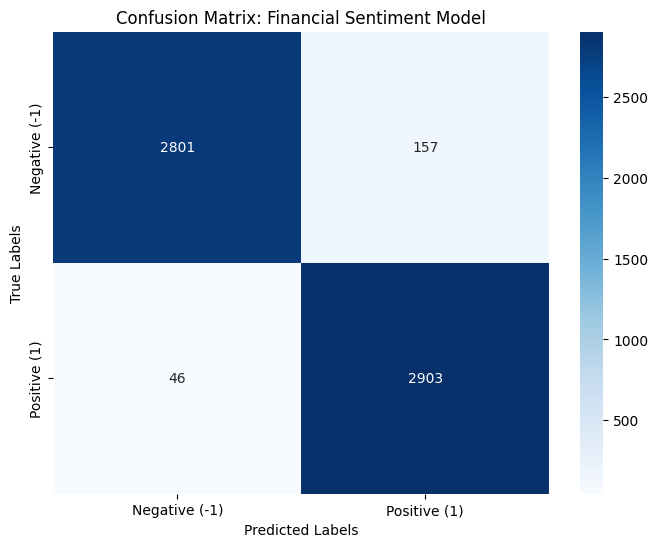

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=[-1, 1])


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative (-1)', 'Positive (1)'],
            yticklabels=['Negative (-1)', 'Positive (1)'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix: Financial Sentiment Model')
plt.show()

In [108]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# 1. Create the UI Elements
text_input = widgets.Textarea(
    value='',
    placeholder='Type a financial headline here...',
    description='Headline:',
    layout={'width': '500px', 'height': '100px'}
)

button = widgets.Button(
    description='Analyze Sentiment',
    button_style='success',
    tooltip='Click to see confidence'
)

output = widgets.Output()

# 2. Define the Logic
def on_button_clicked(b):
    with output:
        clear_output()
        user_text = text_input.value

        if not user_text.strip():
            print("Please enter a headline to analyze.")
            return

        # Transform the text
        test_vector = tfidf.transform([user_text])

        # Get both the Prediction and the Probabilities
        prediction = model.predict(test_vector)[0]
        probabilities = model.predict_proba(test_vector)[0] # Returns [Prob_of_-1, Prob_of_1]

        # Calculate confidence based on the prediction
        # If prediction is 1, take the second value; if -1, take the first
        conf_index = 1 if prediction == 1 else 0
        confidence = probabilities[conf_index] * 100

        # Display results with visual feedback
        print("-" * 50)
        if prediction == 1:
            print(f"RESULT: POSITIVE (1) 🚀")
            print(f"CONFIDENCE: {confidence:.2f}%")
        else:
            print(f"RESULT: NEGATIVE (-1) 📉")
            print(f"CONFIDENCE: {confidence:.2f}%")
        print("-" * 50)

# 3. Link and Display
button.on_click(on_button_clicked)
display(text_input, button, output)

Textarea(value='', description='Headline:', layout=Layout(height='100px', width='500px'), placeholder='Type a …

Button(button_style='success', description='Analyze Sentiment', style=ButtonStyle(), tooltip='Click to see con…

Output()